In [164]:
import random
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split


In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        if isinstance(data, Value):
            data = data.data
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
  
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
    
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
      
        return out
  
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
  
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other

    def __rsub__(self, other):
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
    
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
    
        return out

    def sigmoid(self):
        x = self.data
        s = 1 / (1 + math.exp(-x))
        out = Value(s, (self, ), "sigmoid")

        def _backward():
            self.grad += (s * (1 - s)) * out.grad
        out._backward = _backward

        return out
        
    def exp(self):
        x = self.data
        e = math.exp(x)
        out = Value(e, (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
    
        return out

    def log(self):
        x = self.data
        # Add a small epsilon for stability if x can be zero
        l = math.log(x if x > 0 else 1e-12)
        out = Value(l, (self, ), "log")

        def _backward():
            self.grad += (1/self.data) * out.grad
        out._backward = _backward
        
        return out

    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [ ]:
class Neuron:
    
    def __init__(self, n_in, activation= "tanh"):
        self.w = [Value(random.uniform(-1,1)) for _ in range (n_in)]
        self.b = Value(random.uniform(-1,1))
        self.activation = activation 

    def __call__ (self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        if self.activation == 'tanh':
            return act.tanh()
        elif self.activation == 'sigmoid':
            return act.sigmoid()
        elif self.activation == 'none':
            return act
        else:
           raise ValueError(f"Unknown activation: {self.activation}")

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{self.activation}Neuron({len(self.w)})"
        
class Layer:
    ### FIX 2: ENABLED THE FLEXIBLE INITIALIZER ###
    def __init__(self, n_in, n_out, activation = "tanh"):
        self.neurons = [Neuron(n_in, activation = activation) for _ in range (n_out)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP:

    def __init__(self, n_in, n_outs, activation = None):
        sz = [n_in] + n_outs
        if activation is None:
            activation = ['tanh'] * (len(n_outs) - 1) + ['none']
        self.layers = [Layer(sz[i], sz[i+1], activation=activation[i]) for i in range(len(n_outs))]
    
    def __call__(self, x):
        for layer in self.layers:
          x = layer(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

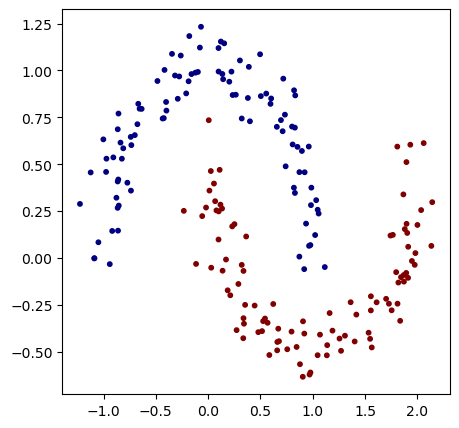

In [162]:
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap='jet')


In [ ]:
model = MLP(2, [16, 16, 1], activation = ["tanh", "tanh", "sigmoid"])
print(model)
print(f"Number of parameters = {len(model.parameters())}")

In [ ]:
def binary_cross_entropy_with_logits(logits, target):
    t = Value(target)
    one = Value(1.0)
    
    # This is a numerically stable way to compute log(sigmoid(logits)) and log(1-sigmoid(logits))
    # log(sigmoid(x)) = -log(1 + exp(-x))
    # log(1-sigmoid(x)) = x - log(1 + exp(x)) -> simpler to use -log(1+exp(x)) + x
    stable_log_sigmoid = -((one + (-logits).exp()).log())
    stable_log_one_minus_sigmoid = -((one + logits.exp()).log())
    
    loss = -(t * stable_log_sigmoid + (one - t) * stable_log_one_minus_sigmoid)
    return loss

In [ ]:
def train(model, X_train, y_train, epochs = 150, batch_size = 4, lr = 0.1):
    
    epoch_losses = []
    
    for epoch in range(epochs):
        combined = list(zip(X_train, y_train))
        random.shuffle(combined)
        shuffled_X, shuffled_y = zip(*combined)

        total_loss = 0.0
        
        for i in range(0, len(shuffled_X), batch_size):
            xb = shuffled_X[i : i+batch_size]
            yb = shuffled_y[i : i+batch_size]

            # Forward Pass
            batch_losses = []
            for x,y in zip(xb, yb):
                y_pred_logits = model(x)
                loss = binary_cross_entropy_with_logits(y_pred_logits, y)
                batch_losses.append(loss)

            batch_loss = sum(batch_losses) * (1.0 / len(batch_losses))
            
            # Backward pass - zero grads first
            for p in model.parameters():
                p.grad = 0.0
            
            batch_loss.backward()
            total_loss += batch_loss.data

            # Update weights
            for p in model.parameters():
                p.data -= lr * p.grad

            batch_losses.append(batch_loss.data)
            
        epoch_loss = total_loss / (len(shuffled_X)/batch_size) 
        epoch_losses.append(epoch_loss)
        
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:3d} : Loss = {total_loss / (len(shuffled_X)/batch_size):.4f}")

    return epoch_losses

In [51]:


def plot_learning_curve(losses):
    """
    Plots the training loss over epochs.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Training Loss')
    plt.title('Learning Curve: Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [53]:
def plot_decision_boundary(model, X, y):

    # Define the grid range with a small padding
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Get predictions for each point on the grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # We need to manually get the predictions as your model expects Value objects
    preds = []
    for point in grid_points:
        # Convert numpy coordinates to Value objects
        val_point = [Value(coord) for coord in point]
        
        # Get the raw logit from the model
        logit = model(val_point)
        
        # Apply sigmoid to the logit to get a probability for visualization
        prob = 1 / (1 + math.exp(-logit.data))
        preds.append(prob)

    Z = np.array(preds).reshape(xx.shape)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    # Plot the colored decision regions
    plt.contourf(xx, yy, Z, cmap='RdBu', alpha=0.8)
    # Overlay the actual data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet', edgecolor='k', s=40)
    plt.title('Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


In [154]:
print(((epoch_losses)))

[0.628006797919172, 0.5749611384711375, 0.5729927532238518, 0.5691477876624084, 0.5682937658147653, 0.5678754437024262, 0.5668615550022393, 0.5669906028009823, 0.5700670687356025, 0.5716598270586709]


In [99]:
import numpy as np

Epoch   0 : Loss = 0.5455
Epoch  10 : Loss = 0.5440
Epoch  20 : Loss = 0.5423
Epoch  30 : Loss = 0.5410
Epoch  40 : Loss = 0.5395
Epoch  50 : Loss = 0.5384
Epoch  60 : Loss = 0.5373
Epoch  70 : Loss = 0.5364
Epoch  80 : Loss = 0.5355
Epoch  90 : Loss = 0.5344
Epoch 100 : Loss = 0.5319
Epoch 110 : Loss = 0.5209
Epoch 120 : Loss = 0.5140
Epoch 130 : Loss = 0.5101
Epoch 140 : Loss = 0.5080
Epoch 150 : Loss = 0.5065
Epoch 160 : Loss = 0.5055
Epoch 170 : Loss = 0.5046
Epoch 180 : Loss = 0.5039
Epoch 190 : Loss = 0.5033
Epoch 199 : Loss = 0.5029


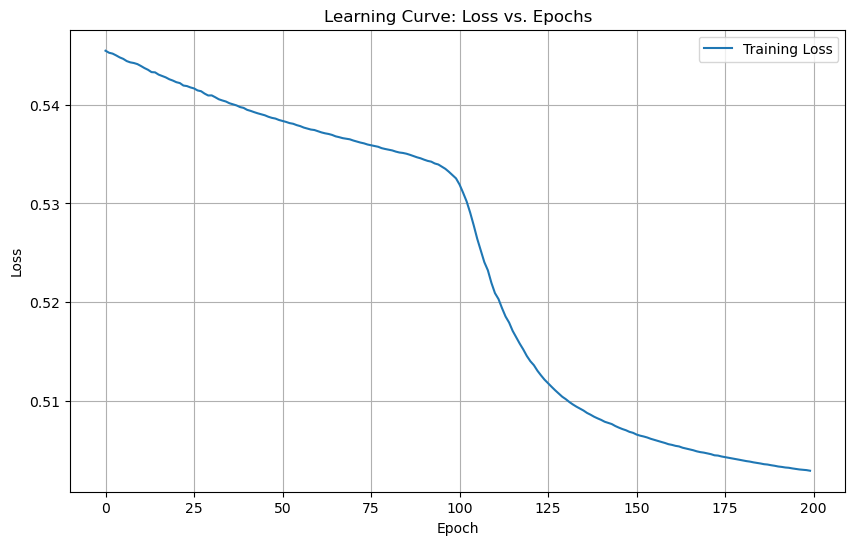

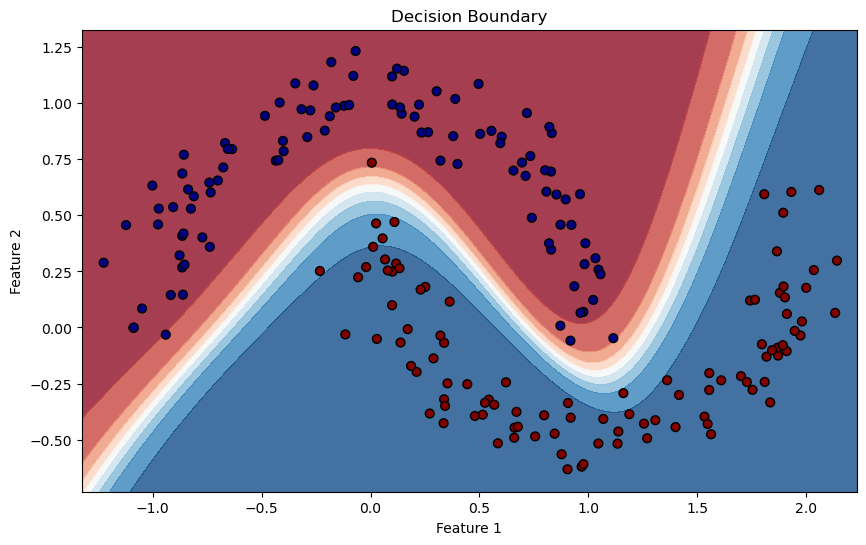

In [160]:
epoch_losses = train(model, X_train, y_train, epochs=200, lr=0.05)


plot_learning_curve(epoch_losses)
plot_decision_boundary(model, X, y)